# 1. model 생성을 위한 units = 0이 아닌 데이터만 뽑아서 만든다

## 1-1 전체 데이터 load

In [2]:
from jw_package import *
from filling_missing import *
from functools import *

import configuration completed !
train + key + weather merging started
train + key + weather merging finished
function configuration completed ! 
Good to go !


In [3]:
weather = pd.read_csv('../data/weather_v4_delete_nan.csv',index_col=0)

In [4]:
sales = pd.read_csv('../data/basic/train.csv')
keys = pd.read_csv('../data/basic/key.csv')

In [5]:
data = sales.merge(keys).merge(weather)

In [5]:
data.head()

,date,store_nbr,item_nbr,units,station_nbr,Unnamed: 0,tmax,tmin,tavg,depart,...,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2012-01-01,2,1,0,14,12,50.0,34.0,42.0,5.0,...,739.0,1729.0,moderate,0.0,0.0,29.13,30.52,11.4,32.0,11.3
1,2012-01-01,2,2,0,14,12,50.0,34.0,42.0,5.0,...,739.0,1729.0,moderate,0.0,0.0,29.13,30.52,11.4,32.0,11.3
2,2012-01-01,2,3,0,14,12,50.0,34.0,42.0,5.0,...,739.0,1729.0,moderate,0.0,0.0,29.13,30.52,11.4,32.0,11.3
3,2012-01-01,2,4,0,14,12,50.0,34.0,42.0,5.0,...,739.0,1729.0,moderate,0.0,0.0,29.13,30.52,11.4,32.0,11.3
4,2012-01-01,2,5,191,14,12,50.0,34.0,42.0,5.0,...,739.0,1729.0,moderate,0.0,0.0,29.13,30.52,11.4,32.0,11.3


## 1-2 tmp 데이터로 copy후 units = 0이 아닌 것만 뽑아서 model 생성

In [6]:
tmp = data.copy()

In [7]:
tmp = tmp[tmp['units']!=0]

In [8]:
# etc = ['day','month','year','station_nbr']
etc = ['station_nbr']
category = ['sunrise','sunset','codesum']

for each in etc+category:
    tmp.drop(each,axis=1,inplace=True)

In [9]:
tmp.columns

Index(['date', 'store_nbr', 'item_nbr', 'units', 'tmax', 'tmin', 'tavg',
       'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'snowfall',
       'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir',
       'avgspeed'],
      dtype='object')

In [10]:
del tmp['tavg']
del tmp['sealevel']
del tmp['wetbulb']
del tmp['stnpressure']
del tmp['tmin']
del tmp['tmax']
del tmp['dewpoint']
del tmp['avgspeed']
del tmp['resultspeed']

In [11]:
tmp.reset_index(drop = True, inplace = True)

In [12]:
tmp.tail()

,date,store_nbr,item_nbr,units,depart,heat,cool,snowfall,preciptotal,resultdir
33218,2014-10-29,36,30,1,3.0,0.0,2.0,0.0,0.0,9.0
33219,2014-10-29,36,44,20,3.0,0.0,2.0,0.0,0.0,9.0
33220,2014-10-31,36,9,29,-4.0,7.0,0.0,0.0,0.0,36.0
33221,2014-10-31,36,30,2,-4.0,7.0,0.0,0.0,0.0,36.0
33222,2014-10-31,36,44,23,-4.0,7.0,0.0,0.0,0.0,36.0


# 2. 이부분은 codesum_v1.csv 데이터 load

In [13]:
codesum = pd.read_csv('../data/weather_v1.csv', index_col = 0)

In [14]:
codesum = codesum.merge(keys, on = 'station_nbr' )

In [15]:
codesum = codesum.loc[:,['date','store_nbr','is_holiday','codesum']]

In [16]:
tmp = tmp.merge(codesum, on = ['date','store_nbr'])

In [17]:
tmp.head()

,date,store_nbr,item_nbr,units,depart,heat,cool,snowfall,preciptotal,resultdir,is_holiday,codesum
0,2012-01-01,2,5,191,5.0,23.0,0.0,0.0,0.0,32.0,holiday,MO
1,2012-01-01,2,44,215,5.0,23.0,0.0,0.0,0.0,32.0,holiday,MO
2,2012-01-01,6,9,44,5.0,23.0,0.0,0.0,0.0,32.0,holiday,MO
3,2012-01-01,6,45,86,5.0,23.0,0.0,0.0,0.0,32.0,holiday,MO
4,2012-01-01,38,9,195,5.0,23.0,0.0,0.0,0.0,32.0,holiday,MO


## 2-1. codesum에서 holiday 컬럼, codesum 컬럼 category변환 함수 
- holiday 이면 1 아니면 0
- codesum 'Not_MO'이면 1 MO 이면 0 

In [18]:
def cate_holiday(holiday):
    if holiday == 'holiday' or holiday == 'holiday_work':
            return 1
    else:
        return 0
def cate_codesum(codesum):
    if codesum == 'MO':
        return 0 
    else:
        return 1
    
tmp['is_holiday'] = tmp['is_holiday'].apply(cate_holiday)
tmp['codesum'] = tmp['codesum'].apply(cate_codesum)

In [19]:
tmp.head()

,date,store_nbr,item_nbr,units,depart,heat,cool,snowfall,preciptotal,resultdir,is_holiday,codesum
0,2012-01-01,2,5,191,5.0,23.0,0.0,0.0,0.0,32.0,1,0
1,2012-01-01,2,44,215,5.0,23.0,0.0,0.0,0.0,32.0,1,0
2,2012-01-01,6,9,44,5.0,23.0,0.0,0.0,0.0,32.0,1,0
3,2012-01-01,6,45,86,5.0,23.0,0.0,0.0,0.0,32.0,1,0
4,2012-01-01,38,9,195,5.0,23.0,0.0,0.0,0.0,32.0,1,0


# 3. model 생성
- formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'

In [20]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'
model = sm.OLS.from_formula(formula, data= tmp)
result = model.fit()

In [21]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     1402.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        03:13:58   Log-Likelihood:            -1.5685e+05
No. Observations:               33223   AIC:                         3.138e+05
Df Residuals:                   33153   BIC:                         3.144e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             49.2206      1.967     25.024      0.000      45.365      53.076
C(store_nbr)[T.6]    -20.5863      1.247    -16.513      0.000     -23.030     -18.143
C(store_nbr)[T.7]     -2.7846      1.115     -2.498      0.012      -4.969      -0.600
C(store_nbr)[T.8]    -23.1206      1.098    -21.062      0.000     -25.272     -20.969
C(store_nbr)[T.12]    17.8884      1.414     12.653      0.000      15.117      20.659
C(store_nbr)[T.13]     5.2945      1.199      4.415      0.000       2.944       7.645
C(store_nbr)[T.16]    12.9661      1.499      8.651      0.000      10.028      15.904
C(store_nbr)[T.19]     0.5954      1.497      0.398      0.691      -2.339       3.530
C(store_nbr)[T.21]   -39.1480      0.970    -40.376      0.000     -41.048     -37.248
C(store_nbr)[T.29]   -22.7943      1.522    -14.975      0.000     -25.778     -19.811
C(store_nbr)[T.30]    24.8244      1.174     21.146      0.000      22.523      27.125
C(store_nbr)[T.33]    52.8267      1.052     50.221      0.000      50.765      54.888
C(store_nbr)[T.36]   -50.4916      1.077    -46.860      0.000     -52.604     -48.380
C(store_nbr)[T.38]     3.8742      1.199      3.230      0.001       1.524       6.225
C(store_nbr)[T.42]   -24.6317      1.109    -22.201      0.000     -26.806     -22.457
C(store_nbr)[T.43]    20.6818      1.460     14.163      0.000      17.820      23.544
C(item_nbr)[T.3]     -70.4152      2.945    -23.907      0.000     -76.188     -64.642
C(item_nbr)[T.5]      15.4216      1.956      7.886      0.000      11.589      19.255
C(item_nbr)[T.7]     -48.5748      2.669    -18.197      0.000     -53.807     -43.343
C(item_nbr)[T.8]       3.5181      2.416      1.456      0.145      -1.217       8.254
C(item_nbr)[T.9]      21.3566      1.824     11.708      0.000      17.781      24.932
C(item_nbr)[T.11]    -51.2463      2.581    -19.855      0.000     -56.305     -46.187
C(item_nbr)[T.13]    -73.6764      2.827    -26.062      0.000     -79.217     -68.136
C(item_nbr)[T.14]    -29.0963      3.012     -9.661      0.000     -34.999     -23.193
C(item_nbr)[T.15]    -44.9479      3.876    -11.597      0.000     -52.545     -37.351
C(item_nbr)[T.16]    -33.4400      2.119    -15.781      0.000     -37.593     -29.287
C(item_nbr)[T.23]    -21.0490      2.156     -9.764      0.000     -25.275     -16.823
C(item_nbr)[T.25]     93.0020      2.495     37.281      0.000      88.112      97.892
C(item_nbr)[T.30]     -0.9817      2.027     -0.484      0.628      -4.955       2.991
C(item_nbr)[T.36]     24.2610      2.367     10.251      0.000      19.622      28.900
C(item_nbr)[T.37]    -55.5469      2.283    -24.326      0.000     -60.023     -51.071
C(item_nbr)[T.39]    -60.3968      3.295    -18.330      0.000     -66.855     -53.938
C(item_nbr)[T.41]     -7.2348      2.4

## 3-1. cross validation 확인

In [22]:
X = tmp.loc[:, ['store_nbr', 'item_nbr', 'cool', 'heat', 'preciptotal','snowfall', 'is_holiday']]
y = tmp.loc[:, ['units']]

In [23]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in cv.split(X):
    print("test index :", test_index, len(test_index))
    print("." * 80)
    print("train index:", train_index, len(train_index))
    print("=" * 80)

    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index, :]
    y_train = y.loc[train_index, :]
    y_test = y.loc[test_index, :]
    
    tmp = pd.concat([X_train, y_train], axis = 1)
    formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'
    
    model = sm.OLS.from_formula(formula, data= tmp)
    result = model.fit()
    
    
    y_hat = result.predict(X_test)
    
    
    
    print(((y_hat - y_hat.mean())**2).sum()  / ((y_test-y_test.mean())**2).sum() )

test index : [    4     6     7 ..., 33216 33219 33222] 8306
................................................................................
train index: [    0     1     2 ..., 33218 33220 33221] 24917
units    0.722486
dtype: float64
test index : [    0     1     3 ..., 33207 33210 33214] 8306
................................................................................
train index: [    2     4     5 ..., 33220 33221 33222] 24917
units    0.767631
dtype: float64
test index : [    2     5    14 ..., 33213 33217 33221] 8306
................................................................................
train index: [    0     1     3 ..., 33219 33220 33222] 24917
units    0.745526
dtype: float64
test index : [   10    11    13 ..., 33208 33218 33220] 8305
................................................................................
train index: [    0     1     2 ..., 33219 33221 33222] 24918
units    0.744682
dtype: float64


# 4. Outlier 제거 코드

In [23]:
res = result.resid_pearson
index = result.resid.index
outlier_index = abs(res) >= 2

row = pd.Series(index=index, data=res)
drop_index = row[outlier_index].index
len(drop_index)

tmp.drop(list(drop_index),inplace=True)
tmp.reset_index(drop = True, inplace = True)

X = tmp.loc[:, ['date', 'store_nbr', 'item_nbr', 'cool', 'heat', 'preciptotal','snowfall', 'is_holiday']]
y = tmp.loc[:, ['units']]

In [24]:
len(tmp)

107962

## 4-1. 2차 제거 후 cross_val 확인
- 위 코드 두번 실행

In [55]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=4, shuffle=True, random_state=0)
for train_index, test_index in cv.split(X):
    print("test index :", test_index, len(test_index))
    print("." * 80)
    print("train index:", train_index, len(train_index))
    print("=" * 80)

    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index, :]
    y_train = y.loc[train_index, :]
    y_test = y.loc[test_index, :]
    
    tmp = pd.concat([X_train, y_train], axis = 1)
    formula = 'units ~ C(store_nbr) + C(item_nbr)+ scale(cool) + scale(heat) + scale(preciptotal) + scale(snowfall) + is_holiday'
    
    model = sm.OLS.from_formula(formula, data= tmp)
    result = model.fit()
    
    
    y_hat = result.predict(X_test)
    
    
    
    print(((y_hat - y_hat.mean())**2).sum()  / ((y_test-y_test.mean())**2).sum() )

test index : [    3     6    17 ..., 49804 49808 49813] 12454
................................................................................
train index: [    0     1     2 ..., 49812 49814 49815] 37362
units    0.928845
dtype: float64
test index : [    4     7     9 ..., 49809 49811 49815] 12454
................................................................................
train index: [    0     1     2 ..., 49812 49813 49814] 37362
units    0.912451
dtype: float64
test index : [    0     1     2 ..., 49799 49802 49807] 12454
................................................................................
train index: [    3     4     5 ..., 49813 49814 49815] 37362
units    0.907719
dtype: float64
test index : [    5    10    11 ..., 49810 49812 49814] 12454
................................................................................
train index: [    0     1     2 ..., 49811 49813 49815] 37362
units    0.920328
dtype: float64


# 4-2. 현재모델

In [27]:
formula = 'units ~ C(store_nbr) + C(item_nbr)+ cool + heat + preciptotal+ snowfall + is_holiday'
model = sm.OLS.from_formula(formula, data= tmp)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  units   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     1035.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        03:15:19   Log-Likelihood:            -1.1785e+05
No. Observations:               24918   AIC:                         2.358e+05
Df Residuals:                   24848   BIC:                         2.364e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             45.6913      2.271     20.121      0.000      41.240      50.142
C(store_nbr)[T.6]    -19.4558      1.455    -13.371      0.000     -22.308     -16.604
C(store_nbr)[T.7]     -2.2963      1.305     -1.760      0.078      -4.854       0.262
C(store_nbr)[T.8]    -21.9335      1.278    -17.160      0.000     -24.439     -19.428
C(store_nbr)[T.12]    17.9438      1.644     10.915      0.000      14.722      21.166
C(store_nbr)[T.13]     7.1046      1.390      5.110      0.000       4.379       9.830
C(store_nbr)[T.16]    13.5597      1.750      7.749      0.000      10.130      16.989
C(store_nbr)[T.19]     0.9428      1.742      0.541      0.588      -2.472       4.358
C(store_nbr)[T.21]   -38.4672      1.131    -34.027      0.000     -40.683     -36.251
C(store_nbr)[T.29]   -21.4319      1.771    -12.101      0.000     -24.903     -17.960
C(store_nbr)[T.30]    25.5526      1.367     18.691      0.000      22.873      28.232
C(store_nbr)[T.33]    52.5666      1.223     42.977      0.000      50.169      54.964
C(store_nbr)[T.36]   -50.3585      1.254    -40.168      0.000     -52.816     -47.901
C(store_nbr)[T.38]     5.3409      1.392      3.836      0.000       2.612       8.070
C(store_nbr)[T.42]   -23.5318      1.287    -18.289      0.000     -26.054     -21.010
C(store_nbr)[T.43]    21.4568      1.705     12.583      0.000      18.114      24.799
C(item_nbr)[T.3]     -71.1367      3.418    -20.813      0.000     -77.836     -64.438
C(item_nbr)[T.5]      14.3058      2.239      6.388      0.000       9.917      18.695
C(item_nbr)[T.7]     -49.3891      3.083    -16.022      0.000     -55.431     -43.347
C(item_nbr)[T.8]       2.7803      2.785      0.998      0.318      -2.679       8.240
C(item_nbr)[T.9]      20.6432      2.084      9.907      0.000      16.559      24.727
C(item_nbr)[T.11]    -51.3337      2.972    -17.272      0.000     -57.159     -45.508
C(item_nbr)[T.13]    -74.5548      3.253    -22.921      0.000     -80.930     -68.179
C(item_nbr)[T.14]    -30.2187      3.534     -8.551      0.000     -37.146     -23.292
C(item_nbr)[T.15]    -44.5700      4.399    -10.133      0.000     -53.191     -35.948
C(item_nbr)[T.16]    -33.8002      2.430    -13.907      0.000     -38.564     -29.036
C(item_nbr)[T.23]    -21.9567      2.475     -8.873      0.000     -26.807     -17.106
C(item_nbr)[T.25]     93.9443      2.880     32.617      0.000      88.299      99.590
C(item_nbr)[T.30]     -0.9417      2.335     -0.403      0.687      -5.519       3.635
C(item_nbr)[T.36]     22.4868      2.721      8.265      0.000      17.154      27.819
C(item_nbr)[T.37]    -55.8802      2.628    -21.264      0.000     -61.031     -50.729
C(item_nbr)[T.39]    -60.9437      3.871    -15.743      0.000     -68.532     -53.356
C(item_nbr)[T.41]     -8.8583      2.7

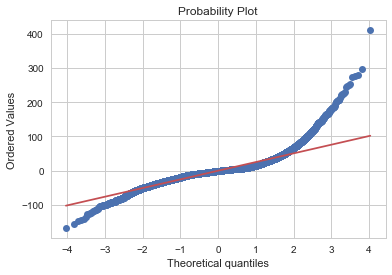

In [28]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [29]:
test = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 11004.567
P-value     :  0.000


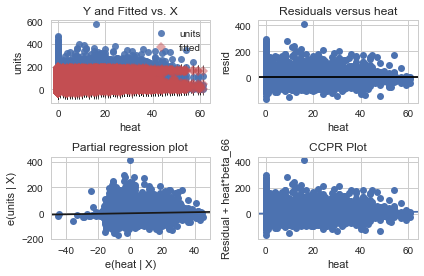

In [30]:
fig = sm.graphics.plot_regress_exog(result, "heat")
fig.suptitle("")
plt.show()

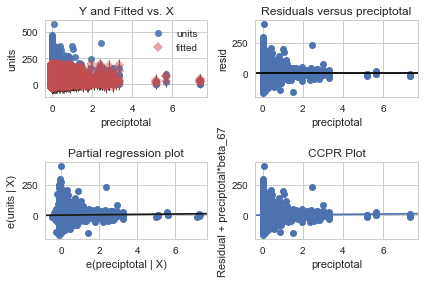

In [31]:
fig = sm.graphics.plot_regress_exog(result, "preciptotal")
fig.suptitle("")
plt.show()

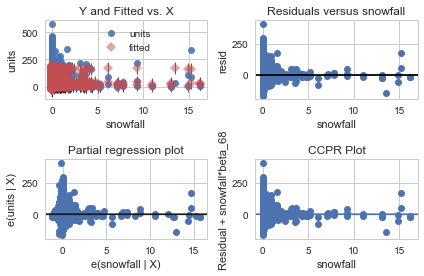

In [32]:
fig = sm.graphics.plot_regress_exog(result, "snowfall")
fig.suptitle("")
plt.show()

# 5. test.csv load

In [56]:
test = pd.read_csv('../data/basic/test.csv', index_col = 0)

In [57]:
test.reset_index(inplace = True)

In [58]:
test.tail()

,date,store_nbr,item_nbr
526912,2014-10-26,45,107
526913,2014-10-26,45,108
526914,2014-10-26,45,109
526915,2014-10-26,45,110
526916,2014-10-26,45,111


## 5-1. test 데이터에 weather's feature merge후 test_df로 저장

In [59]:
test_df = test.merge(keys).merge(weather)

In [60]:
test_df.tail()

,date,store_nbr,item_nbr,station_nbr,tmax,tmin,tavg,depart,dewpoint,wetbulb,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day,codesum
526912,2014-08-02,40,107,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,
526913,2014-08-02,40,108,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,
526914,2014-08-02,40,109,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,
526915,2014-08-02,40,110,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,
526916,2014-08-02,40,111,13,81.0,51.0,66.0,3.0,47.0,56.0,...,0.0,24.44,30.12,5.7,17.0,6.5,2014,8,2,


In [61]:
etc = ['day','month','year', 'tavg', 'sealevel', 'wetbulb', 'stnpressure', 'tmin', 'tmax', 'dewpoint', 'avgspeed', 'resultspeed']
category = ['sunrise','sunset','codesum']

for each in etc+category:
    test_df.drop(each,axis=1,inplace=True)

In [62]:
test_df.tail()

,date,store_nbr,item_nbr,station_nbr,depart,heat,cool,snowfall,preciptotal,resultdir
526912,2014-08-02,40,107,13,3.0,0.0,1.0,0.0,0.0,17.0
526913,2014-08-02,40,108,13,3.0,0.0,1.0,0.0,0.0,17.0
526914,2014-08-02,40,109,13,3.0,0.0,1.0,0.0,0.0,17.0
526915,2014-08-02,40,110,13,3.0,0.0,1.0,0.0,0.0,17.0
526916,2014-08-02,40,111,13,3.0,0.0,1.0,0.0,0.0,17.0


In [63]:
test_df = test_df.merge(codesum, on = ['date','store_nbr'])
test_df['is_holiday'] = test_df['is_holiday'].apply(cate_holiday)
test_df['codesum'] = test_df['codesum'].apply(cate_codesum)

## 5-2. test_df에서 팔린 units의 feature에 대해서만 선택후 test_X_df에 저장

In [64]:
test_X_df = pd.DataFrame(columns=['date', 'store_nbr', 'item_nbr', 'station_nbr', 'cool', 'depart', 'heat', 'preciptotal', 'resultdir', 'snowfall', 'is_holiday', 'codesum'])

for nbr in range(1, 45+1):
    store_nbr = tmp[tmp['store_nbr'].isin([nbr])]
    sold_item_list = list(store_nbr['item_nbr'].unique())
    sold_item_list

    test_store_nbr = test_df[test_df['store_nbr'].isin([nbr])]
    to_test_df = test_store_nbr[test_store_nbr['item_nbr'].isin(sold_item_list)]

    test_X_df = pd.concat([test_X_df, to_test_df], axis = 0)
    
test_X_df.shape

(25267, 12)

In [65]:
test_X_df.head()

,codesum,cool,date,depart,heat,is_holiday,item_nbr,preciptotal,resultdir,snowfall,station_nbr,store_nbr
484301,0,0.0,2013-06-04,9.0,3.0,0,9,0.0,31.0,0.0,1,1
484320,0,0.0,2013-06-04,9.0,3.0,0,28,0.0,31.0,0.0,1,1
484332,0,0.0,2013-06-04,9.0,3.0,0,40,0.0,31.0,0.0,1,1
484339,0,0.0,2013-06-04,9.0,3.0,0,47,0.0,31.0,0.0,1,1
484343,0,0.0,2013-06-04,9.0,3.0,0,51,0.0,31.0,0.0,1,1


In [66]:
test_X_df.head()

,codesum,cool,date,depart,heat,is_holiday,item_nbr,preciptotal,resultdir,snowfall,station_nbr,store_nbr
484301,0,0.0,2013-06-04,9.0,3.0,0,9,0.0,31.0,0.0,1,1
484320,0,0.0,2013-06-04,9.0,3.0,0,28,0.0,31.0,0.0,1,1
484332,0,0.0,2013-06-04,9.0,3.0,0,40,0.0,31.0,0.0,1,1
484339,0,0.0,2013-06-04,9.0,3.0,0,47,0.0,31.0,0.0,1,1
484343,0,0.0,2013-06-04,9.0,3.0,0,51,0.0,31.0,0.0,1,1


## 5-3. test_df와 type을 맞춰줘야함 그래야 predict()에 넣을 수 있다.

In [67]:
test_X_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25267 entries, 484301 to 514074
Data columns (total 12 columns):
codesum        25267 non-null object
cool           25267 non-null float64
date           25267 non-null object
depart         25267 non-null float64
heat           25267 non-null float64
is_holiday     25267 non-null object
item_nbr       25267 non-null object
preciptotal    25267 non-null float64
resultdir      25267 non-null float64
snowfall       25267 non-null float64
station_nbr    25267 non-null object
store_nbr      25267 non-null object
dtypes: float64(6), object(6)
memory usage: 2.5+ MB


In [68]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526917 entries, 0 to 526916
Data columns (total 12 columns):
date           526917 non-null object
store_nbr      526917 non-null int64
item_nbr       526917 non-null int64
station_nbr    526917 non-null int64
depart         526917 non-null float64
heat           526917 non-null float64
cool           526917 non-null float64
snowfall       526917 non-null float64
preciptotal    526917 non-null float64
resultdir      526917 non-null float64
is_holiday     526917 non-null int64
codesum        526917 non-null int64
dtypes: float64(6), int64(5), object(1)
memory usage: 52.3+ MB


In [69]:
test_X_df['store_nbr'] = test_X_df['store_nbr'].astype(int)
test_X_df['item_nbr'] = test_X_df['item_nbr'].astype(int)
test_X_df['station_nbr'] = test_X_df['station_nbr'].astype(int)
test_X_df['is_holiday'] = test_X_df['is_holiday'].astype(int)
test_X_df['codesum'] = test_X_df['codesum'].astype(int)

## 5-4. 이제 test_X_df 를 predict() 하면

In [70]:
y_hat = result.predict(test_X_df)

In [71]:
y_df = test_df.loc[:,['date','store_nbr','item_nbr']]

In [72]:
y_df['units'] = y_hat

In [73]:
y_df.tail()

,date,store_nbr,item_nbr,units
526912,2014-08-02,40,107,NaN
526913,2014-08-02,40,108,NaN
526914,2014-08-02,40,109,NaN
526915,2014-08-02,40,110,NaN
526916,2014-08-02,40,111,NaN


In [74]:
def itiszero(units):
    if units > 0:
        return units
    else:
        return 0

In [75]:
y_df['units'] = y_df['units'].apply(itiszero)

In [76]:
y_df['units'] = y_df['units'].astype(int)

In [77]:
y_df

,date,store_nbr,item_nbr,units
0,2013-04-01,2,1,0
1,2013-04-01,2,2,0
2,2013-04-01,2,3,0
3,2013-04-01,2,4,0
4,2013-04-01,2,5,51
5,2013-04-01,2,6,0
6,2013-04-01,2,7,0
7,2013-04-01,2,8,0
8,2013-04-01,2,9,0
9,2013-04-01,2,10,0


# 6. 제출 형식에 맞게 수정 후 .csv파일로 저장

In [78]:
y_df['id'] = y_df['store_nbr'].astype(str)+"_"+y_df['item_nbr'].astype(str)+'_'+y_df['date'].astype(str)

In [79]:
for_submission = y_df.loc[:,['id','units']]

In [80]:
for_submission.head()

,id,units
0,2_1_2013-04-01,0
1,2_2_2013-04-01,0
2,2_3_2013-04-01,0
3,2_4_2013-04-01,0
4,2_5_2013-04-01,51


In [81]:
for_submission.to_csv('best_close_submission.csv', index = False)